# MatrixMatch

In [1]:
import time
begin_start_time = time.time()
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
print(time_str)

2025-12-29 14-01-23


In [2]:
import torch, pandas as pd, os
import matplotlib.pyplot as plt
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
from PPO.ppo_agent_eval import *
from DQN.h2h_to_excel import append_h2h_to_excel
from C4.eval_oppo_dict import *
from C4.CNet192 import CNet192, save_cnet192, load_cnet192
from C4.utilities import make_hof_metascores

In [4]:
ENSEMBLE = [
    "PPO_Models/MIX_10.pt",   # EXPERT_2 -> MIX_1 -> MIX_3 -> MIX_4 -> MIX_9 -> MIX_10

    #"PPO_Models/MIX_6a.pt",   # EXPERT_3 -> MIX_5 -> MIX_6a
    #"PPO_Models/MIX_6b.pt",   # EXPERT_3 -> MIX_5 -> MIX_6b
    
    "PPO_Models/MIX_7a.pt",   # EXPERT_3 -> MIX_5 -> MIX_6b -> MIX_7a
    "PPO_Models/MIX_7b.pt",   # EXPERT_3 -> MIX_5 -> MIX_6b -> MIX_7b
    "PPO_Models/MIX_8.pt",   # EXPERT_3 -> MIX_5 -> MIX_6a -> MIX_8

    "PPO_Models/MIX_11.pt",   # EXPERT_3 -> MIX_5 -> MIX_6b -> MIX_7b -> MIX_11
    
    #"SupervisedModels/EXPERT_2.pt", # used for training MIX_1
    #"SupervisedModels/EXPERT_3.pt", # used for training MIX_5 
  
]

In [5]:
policies = {}

for path in ENSEMBLE:
    name = path.split("/")[-1].split(".")[0]
    m, _ = load_cnet192(path, device=DEVICE, strict=True)
    m.eval()
    policies[name] = m
    

In [6]:
mat, details = round_robin_matrix(
    policies,
    n_games=500,
    device=DEVICE,
    opening_noise_k=OPENING_NOISE_K,
    seed=123,
    progress=True,
    paired_openings=True,
    opening_bias="center",
    return_details=True,
)
meta = metascores_from_matrix(mat)

Round-robin:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
display(mat)

,MIX_10,MIX_7a,MIX_7b,MIX_8,MIX_11
MIX_10,0.500,0.497,0.311,0.323,0.307
MIX_7a,0.503,0.500,0.488,0.513,0.500
MIX_7b,0.689,0.512,0.500,0.510,0.102
MIX_8,0.677,0.487,0.490,0.500,0.102
MIX_11,0.693,0.500,0.898,0.898,0.500


In [8]:
display(meta)

MIX_10    0.35950
MIX_7a    0.50100
MIX_7b    0.45325
MIX_8     0.43900
MIX_11    0.74725
Name: meta_score, dtype: float64

In [9]:
print(make_hof_metascores(meta, ENSEMBLE, decimals=6))

HOF_METASCORES = {
    "PPO_Models/MIX_11.pt": 0.747250,
    "PPO_Models/MIX_7a.pt": 0.501000,
    "PPO_Models/MIX_7b.pt": 0.453250,
    "PPO_Models/MIX_8.pt": 0.439000,
    "PPO_Models/MIX_10.pt": 0.359500,
}


In [10]:
OUT_DIR = "Logs/PPO_matrix/"
matches_df, ranking = export_round_robin_bundle_to_excel(mat, details, out_dir=OUT_DIR)

Saved matrix / matches / ranking to Logs/PPO_matrix/


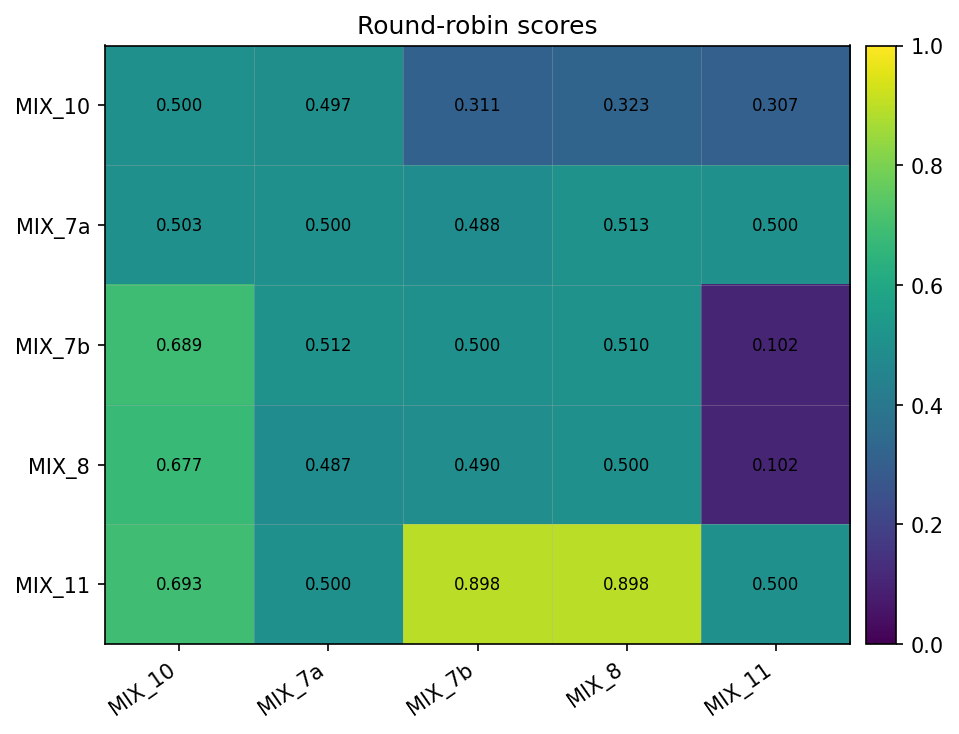

In [11]:
fig = plot_rr_heatmap(mat, title="Round-robin scores")
plt.show()

In [12]:
end_time = time.time()
total_elapsed = (end_time - begin_start_time) / 60
print(f"Evaluation completed in {total_elapsed:.1f} minutes")

Evaluation completed in 1.4 minutes
